In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import zlib
import numpy as np
import base64
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision import models
from torchvision.models import ResNet18_Weights

In [2]:
def mask_to_binary(mask_data, height=512, width=512):
    mask = np.frombuffer(mask_data, dtype=np.uint8).reshape(height, width)
    binary_mask = mask != 0  # Converting mask to binary
    return binary_mask

In [3]:
df1 = pd.read_csv("../Frame Selection/dataset.csv")
df2 = pd.read_csv("../imagefeedback.csv", delimiter=";")
df3 = pd.read_csv("../image.csv", delimiter=";", on_bad_lines='skip')

# Merge datasets, retain relevant columns, and remove rows with missing "SIDE" values
df = (pd.merge(df1, df2, left_on='image_id', right_on='IMAGE_ID', how='inner')
        [['image_id', 'segmentation', 'SIDE']]
        .dropna(subset=['SIDE']))

# Decode and decompress the 'segmentation' column
df['segmentation'] = df['segmentation'].apply(lambda x: zlib.decompress(base64.b64decode(x)))

# Filter rows where 'segmentation' column has the exact size of 262144
df = df[df['segmentation'].apply(len) == 262144]

# Merge with additional dataset, remove duplicates, and drop rows with missing "SIDE"
df = (pd.merge(df, df3, left_on='image_id', right_on='ID', how='inner')
        [['image_id', 'segmentation', 'SIDE', 'PATIENTID', 'STUDY_ID']]
        .drop_duplicates()
        .dropna(subset=['SIDE']))

# Remove duplicate masks (we have only one case like this)
df = df.drop_duplicates(subset='segmentation')

# Ensure 'segmentation' column contains byte data, then convert masks to binary
df = df[df['segmentation'].apply(lambda x: isinstance(x, bytes))]
df['segmentation'] = df['segmentation'].apply(mask_to_binary)

# Reset index to maintain data consistency
df = df.reset_index(drop=True)
df = df.reset_index()

In [4]:
df.head()

,index,image_id,segmentation,SIDE,PATIENTID,STUDY_ID
0,0,131aedfhs6pnf1fvtvp49mjf02x1fl1f22,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
1,1,131aedfhs6pnf1fvtvp49mjf04wc7y5722,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
2,2,131aedfhs6pnf1fvtvp49mjf04y0vtqu22,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
3,3,131aedfhs6pnf1fvtvp49mk5l3qcg5hh22,"[[False, False, False, False, False, False, Fa...",0.0,id013,1.3.46.670589.28.68172260235162120220603125733...
4,4,131aedfhs6pnf1fvtvp49mk5l3ra0gpr22,"[[False, False, False, False, False, False, Fa...",0.0,id013,1.3.46.670589.28.68172260235162120220603125733...


In [5]:
def get_model():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, loss_fn, optimizer = get_model()
model.to(device)
print("")

In [7]:
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device count: {torch.cuda.device_count()}')
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')
    print(f"Used device: {device}")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Used device: cuda


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        mask_array = self.dataframe.iloc[idx]['segmentation']
        label = self.dataframe.iloc[idx]['SIDE']
        mask_image = Image.fromarray(mask_array.astype(np.uint8) * 255).convert("L")
        id = self.dataframe.iloc[idx]['index']
        
        if self.transform:
            mask_tensor = self.transform(mask_image)
        else:
            mask_tensor = transforms.ToTensor()(mask_image)
            
        return mask_tensor, torch.tensor(label, dtype=torch.float32), id

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [9]:
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    valid_losses = []
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels, idx in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels, idx in valid_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item() * images.size(0)
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses

In [10]:
uniq_ids = df['image_id'].unique()
np.random.shuffle(uniq_ids)
print("Unique image ids: ", len(uniq_ids))

Unique image ids:  484


In [11]:
# This function splits the dataset into k nearly equal folds for cross-validation. 
# It ensures that all masks for a specific image are placed in the same fold to avoid overestimating model performance.

def split_dataset(dataset, k):
    subset_size = len(dataset) // k
    residual = len(dataset) % k
    subsets = []
    start = 0
    
    for i in range(k):
        if i < residual:
            end = start + subset_size + 1
        else:
            end = start + subset_size

        subsets.append(dataset[start:end])
        start = end

    return subsets

subsets = split_dataset(uniq_ids, 8)
len(subsets)

df_subsets = []

for subset in subsets:
    df_subsets.append(df[df['image_id'].isin(subset)])

In [12]:
for i, sub in enumerate(df_subsets):
    print(f"fold {i+1}, number of elements: {len(sub)}")

fold 1, number of elements: 109
fold 2, number of elements: 112
fold 3, number of elements: 108
fold 4, number of elements: 124
fold 5, number of elements: 111
fold 6, number of elements: 111
fold 7, number of elements: 108
fold 8, number of elements: 105


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    wrong_predicted_idx = []
    
    with torch.no_grad():
        for images, labels, idx in data_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            result = (preds == labels)

            for i, res in enumerate(result):
                if not res:
                    wrong_predicted_idx.append(idx[i].item())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, wrong_predicted_idx

In [14]:
def train_model_CV(folds, num_epochs=10, batch_size=32):
    fold_train_losses = []
    fold_valid_losses = []
    all_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'wrong_predicted_idx': []}

    for fold, valid_df in enumerate(folds):
        print(f"Fold {fold+1}/{len(folds)}")

        model, loss_fn, optimizer = get_model() # resetting model for each fold
        
        train_folds_list =  [df for idx, df in enumerate(folds) if idx != fold]
        train_df = pd.concat(train_folds_list, ignore_index=True)
        
        train_dataset = CustomDataset(train_df, transform=transform)
        valid_dataset = CustomDataset(valid_df, transform=transform)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size) 

        train_losses, valid_losses = train_model(model, train_loader, valid_loader, loss_fn, optimizer, num_epochs=num_epochs)
        fold_train_losses.append(train_losses)
        fold_valid_losses.append(valid_losses)

        # evaluating metrics on validation set
        accuracy, precision, recall, f1, wrong_predicted_idx = evaluate_model(model, valid_loader)
        all_metrics['accuracy'].append(accuracy)
        all_metrics['precision'].append(precision)
        all_metrics['recall'].append(recall)
        all_metrics['f1'].append(f1)
        all_metrics['wrong_predicted_idx'].append(wrong_predicted_idx)
        
    return fold_train_losses, fold_valid_losses, all_metrics

In [15]:
fold_train_losses, fold_valid_losses, all_metrics = train_model_CV(df_subsets, num_epochs=10, batch_size=32)

Fold 1/8
Epoch 1/10, Train Loss: 0.3609, Valid Loss: 0.4456
Epoch 2/10, Train Loss: 0.1396, Valid Loss: 0.6099
Epoch 3/10, Train Loss: 0.0727, Valid Loss: 0.0554
Epoch 4/10, Train Loss: 0.0538, Valid Loss: 0.0512
Epoch 5/10, Train Loss: 0.0460, Valid Loss: 0.0462
Epoch 6/10, Train Loss: 0.0317, Valid Loss: 0.0746
Epoch 7/10, Train Loss: 0.0274, Valid Loss: 0.0503
Epoch 8/10, Train Loss: 0.0640, Valid Loss: 0.1502
Epoch 9/10, Train Loss: 0.0354, Valid Loss: 0.0896
Epoch 10/10, Train Loss: 0.0271, Valid Loss: 0.0375
Fold 2/8
Epoch 1/10, Train Loss: 0.3490, Valid Loss: 0.5697
Epoch 2/10, Train Loss: 0.0993, Valid Loss: 0.4251
Epoch 3/10, Train Loss: 0.0845, Valid Loss: 0.0790
Epoch 4/10, Train Loss: 0.0389, Valid Loss: 0.0516
Epoch 5/10, Train Loss: 0.0370, Valid Loss: 0.0838
Epoch 6/10, Train Loss: 0.0412, Valid Loss: 0.0525
Epoch 7/10, Train Loss: 0.0558, Valid Loss: 0.0658
Epoch 8/10, Train Loss: 0.1044, Valid Loss: 0.0488
Epoch 9/10, Train Loss: 0.0233, Valid Loss: 0.0339
Epoch 10/10,

C:\Users\karol\anaconda3\envs\MedicalComputerScience\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10, Train Loss: 0.3594, Valid Loss: 0.7955
Epoch 2/10, Train Loss: 0.1104, Valid Loss: 0.8462
Epoch 3/10, Train Loss: 0.0888, Valid Loss: 0.0643
Epoch 4/10, Train Loss: 0.0683, Valid Loss: 0.0310
Epoch 5/10, Train Loss: 0.0619, Valid Loss: 0.0530
Epoch 6/10, Train Loss: 0.0444, Valid Loss: 0.0320
Epoch 7/10, Train Loss: 0.0426, Valid Loss: 0.0909
Epoch 8/10, Train Loss: 0.0229, Valid Loss: 0.0316
Epoch 9/10, Train Loss: 0.0205, Valid Loss: 0.0599
Epoch 10/10, Train Loss: 0.0215, Valid Loss: 0.0249
Fold 5/8
Epoch 1/10, Train Loss: 0.4434, Valid Loss: 0.5988
Epoch 2/10, Train Loss: 0.1571, Valid Loss: 0.1735
Epoch 3/10, Train Loss: 0.0823, Valid Loss: 0.0510
Epoch 4/10, Train Loss: 0.0779, Valid Loss: 0.0531
Epoch 5/10, Train Loss: 0.0746, Valid Loss: 0.1861
Epoch 6/10, Train Loss: 0.0805, Valid Loss: 0.1023
Epoch 7/10, Train Loss: 0.0316, Valid Loss: 0.0378
Epoch 8/10, Train Loss: 0.0338, Valid Loss: 0.0472
Epoch 9/10, Train Loss: 0.0243, Valid Loss: 0.0351
Epoch 10/10, Train Lo

In [21]:
# ostatni_klucz, ostatnia_wartosc = list(slownik.items())[-1]

last_key, wrong_pred_idx = list(all_metrics.items())[-1]
wrong_pred_idx
del all_metrics[last_key]

In [22]:
# Calculate mean and standard deviation for each metric
for metric, values in all_metrics.items():
    mean_value = np.mean(values)
    print(f"{metric.capitalize()}: {mean_value:.4f}")

Accuracy: 0.9863
Precision: 0.9744
Recall: 0.9886
F1: 0.9811


In [23]:
def plot_learning_curves(valid_losses):
    epochs = list(range(1, len(valid_losses) + 1))
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation Loss')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

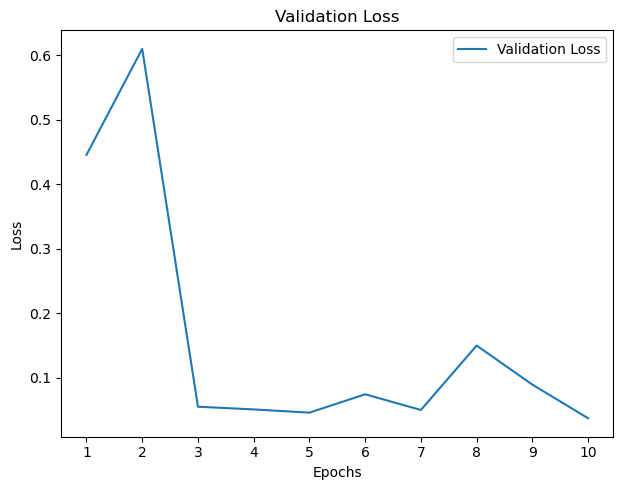

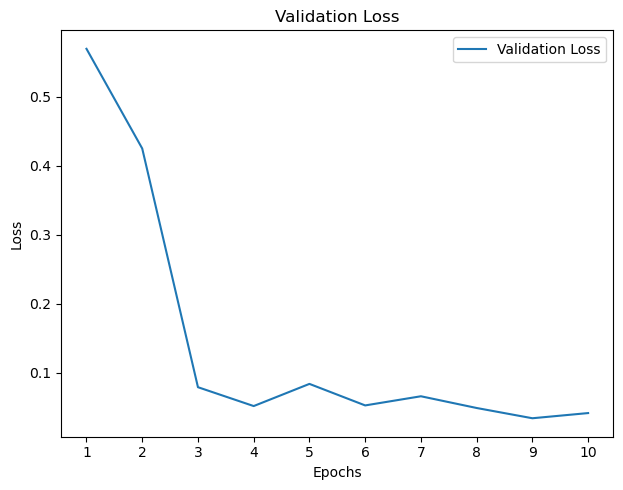

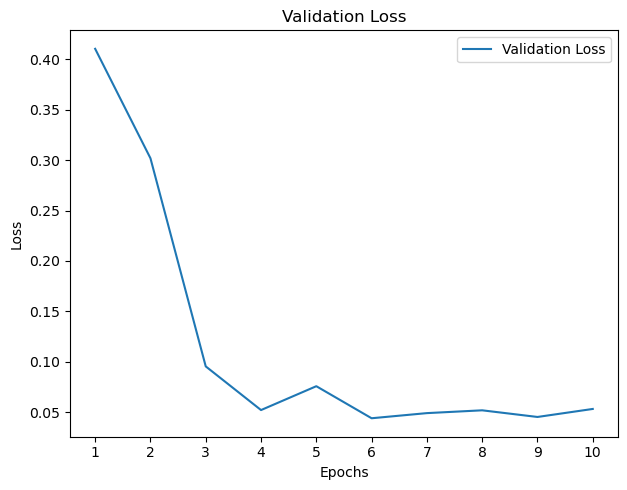

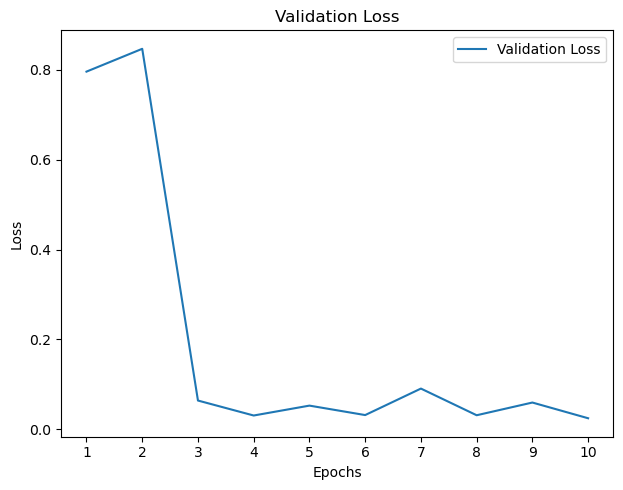

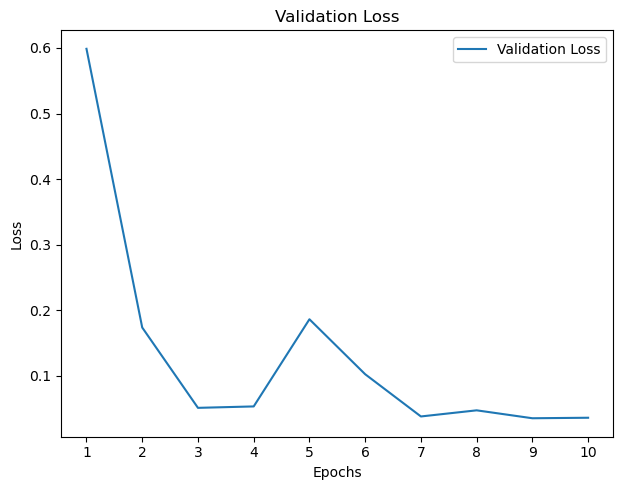

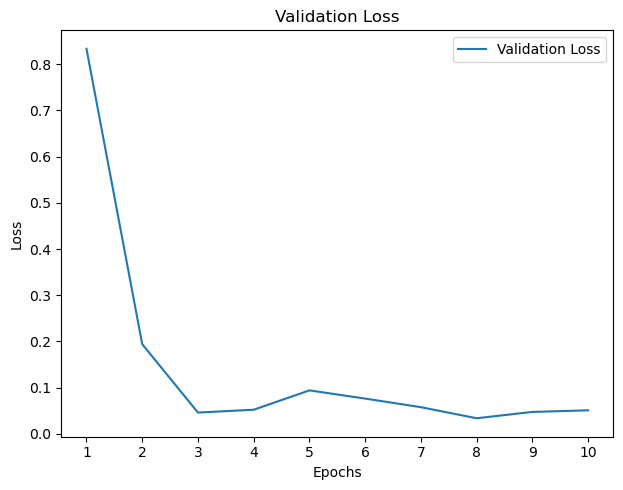

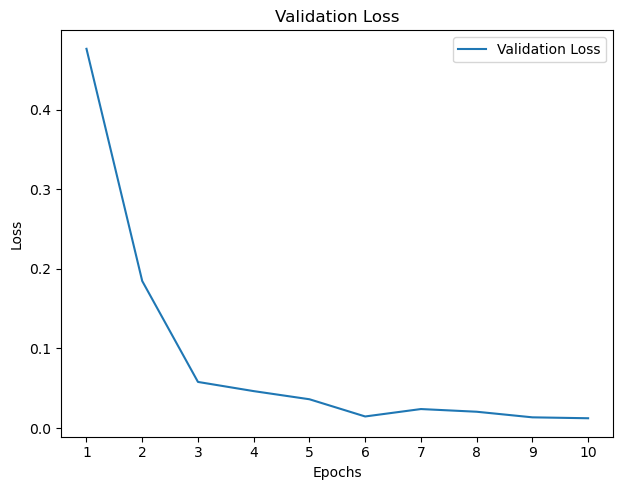

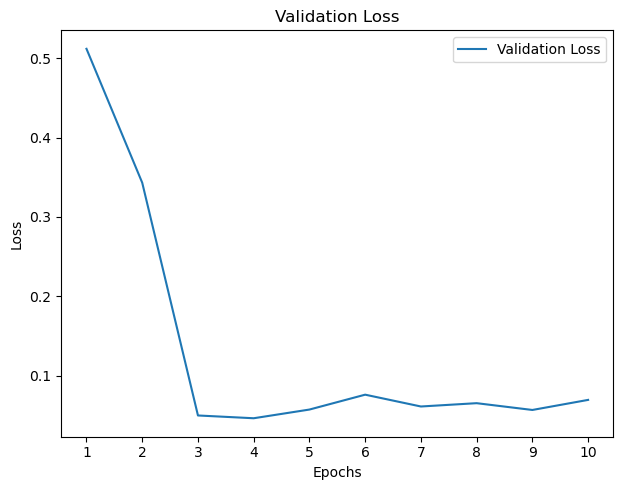

In [24]:
for fold_losses in fold_valid_losses:
    plot_learning_curves(fold_losses)

In [25]:
def display_wrong_predictions(df, wrong):
    plt.figure(figsize=(10, 10))

    FP = 0
    FN = 0
    for i, val in enumerate(wrong, start=1):
        plt.subplot(1, len(wrong), i)
        plt.imshow(df.loc[val, 'segmentation'])
        plt.axis('off')
        if df.loc[val, 'SIDE'] == 1.0:
            FN += 1
        else:
            FP += 1
        title = "True label: RCA" if df.loc[val, 'SIDE'] == 1.0 else "True label: LCA"
        plt.title(title)

    plt.tight_layout()
    plt.show()
    return FP, FN

<Positive: RCA>


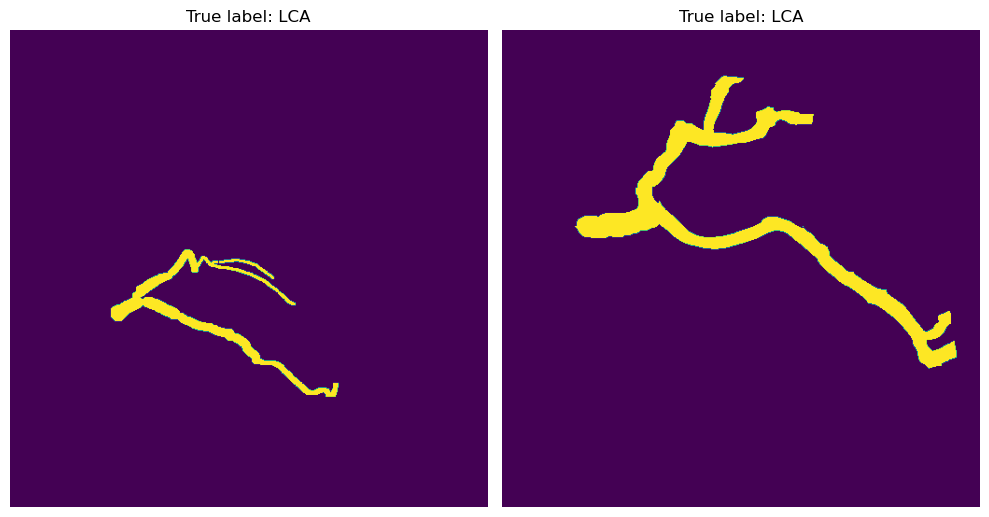

FP:  2
FN:  0


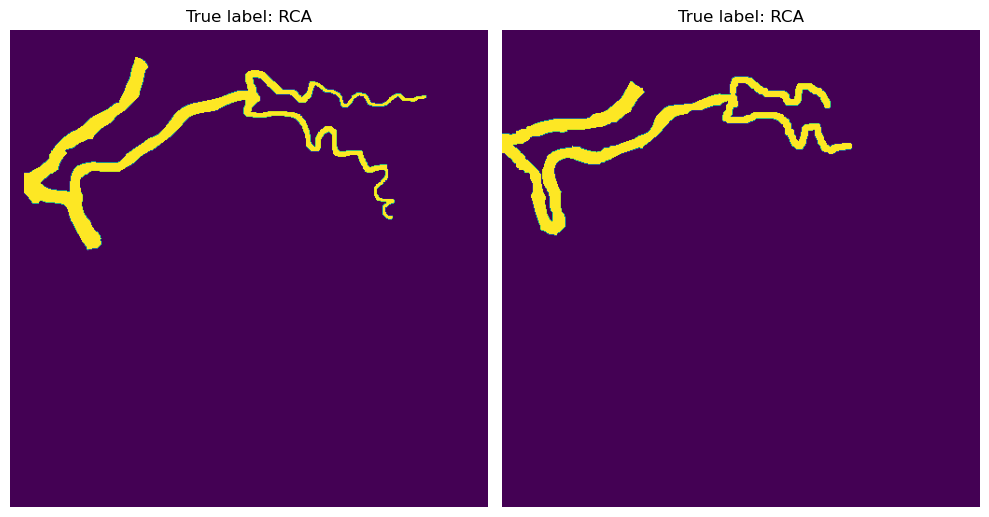

FP:  0
FN:  2


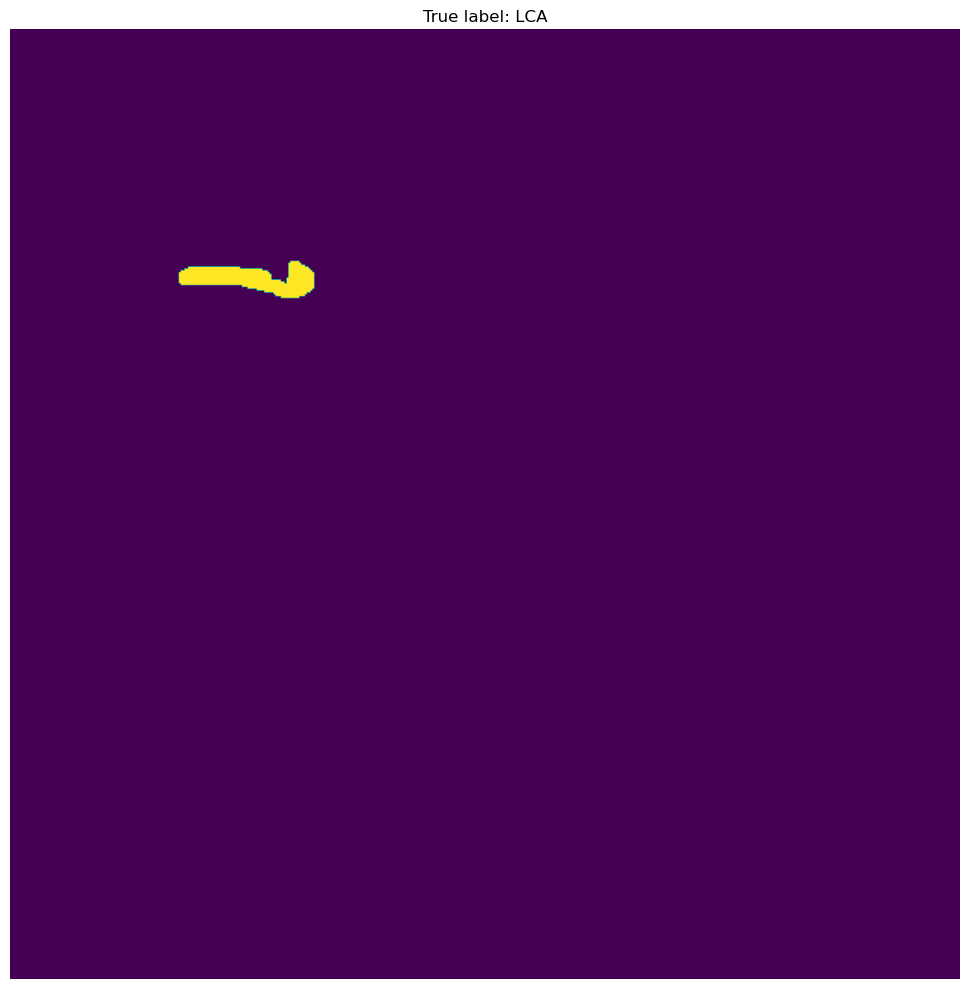

FP:  1
FN:  0


<Figure size 1000x1000 with 0 Axes>

FP:  0
FN:  0


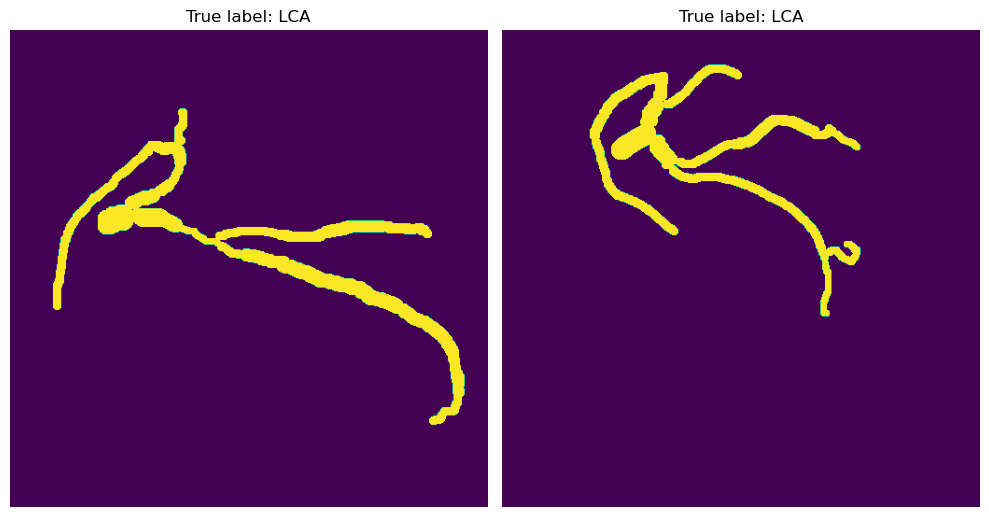

FP:  2
FN:  0


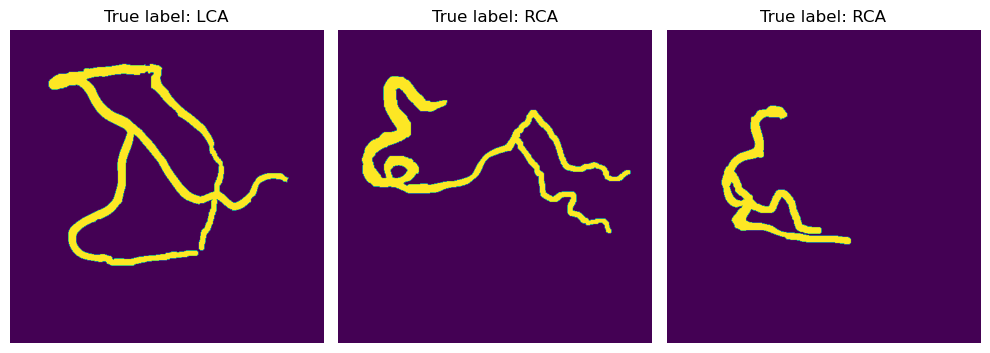

FP:  1
FN:  2


<Figure size 1000x1000 with 0 Axes>

FP:  0
FN:  0


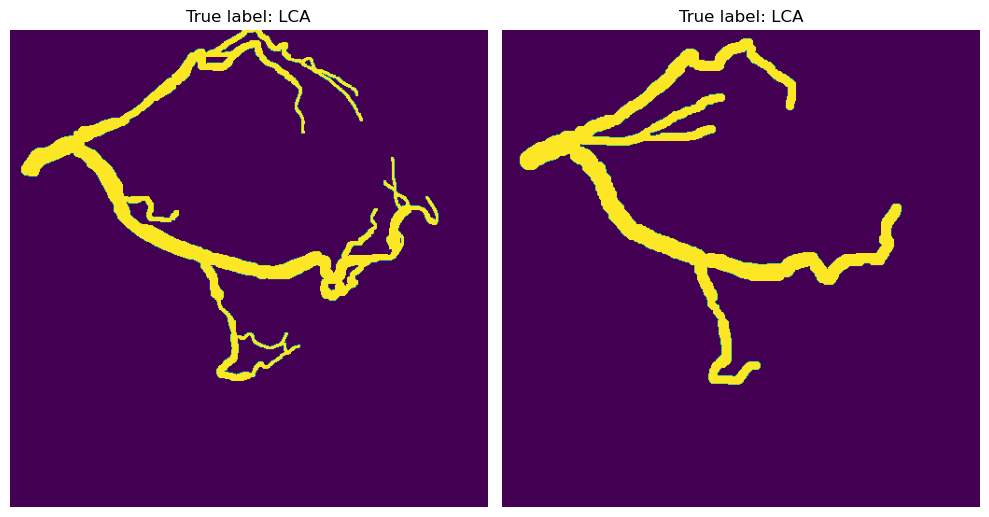

FP:  2
FN:  0


In [35]:
TP = df['SIDE'].value_counts().get(1.0)
TN = df['SIDE'].value_counts().get(0.0)

print("<Positive: RCA>")

for wrong_idx_fold in wrong_pred_idx:
    FP, FN = display_wrong_predictions(df, wrong_idx_fold)

    print("FP: ", FP)
    print("FN: ", FN)